In [6]:
CLIENT_ID = "135966"
CLIENT_SECRET = "495573d44d4c6011506da5ede8e20afece736262"
REFRESH_TOKEN = "f7542124498ccb69c43c055ec21b45f4b68c1147"

# Overview
## Here's what we'll aim to achieve:

### List your runs 
Display your runs in a structured format.
### Calculate Personal Records (PRs)
Identify your best times over standard distances, considering all sub-runs.
### Visualize PRs
Plot your best pace against distance.
### Create an Animated History of PRs
Show how your PRs have evolved over time.
### Optional - Update Strava Descriptions
Add insights back to your Strava run descriptions (requires Strava API access with write permissions).


In [1]:
import pandas as pd
from datetime import timedelta

# Load your data
df = pd.read_csv('data/my_activity_data=20240926202601.csv')

# Filter for running activities
running_df = df[df['sport_type'] == 'Run'].copy()

# Convert date columns to datetime
running_df['start_date'] = pd.to_datetime(running_df['start_date'])

# Calculate pace in min/km
running_df['distance_km'] = running_df['distance'] / 1000
running_df['pace_min_per_km'] = (running_df['moving_time'] / 60) / running_df['distance_km']

# Create a display DataFrame
display_df = running_df[['start_date', 'distance_km', 'moving_time', 'pace_min_per_km', 'id']].copy()

# Format moving_time
display_df['moving_time'] = display_df['moving_time'].apply(lambda x: str(timedelta(seconds=x)))

# Format pace
display_df['pace_min_per_km'] = display_df['pace_min_per_km'].apply(lambda x: f"{int(x):02d}'{int((x - int(x)) * 60):02d}\"/km")

# Add URL (assuming you have your athlete ID)
athlete_id = 'your_athlete_id'  # Replace with your actual athlete ID
display_df['url'] = 'https://www.strava.com/activities/' + running_df['id'].astype(str)

# Reset index for display purposes
display_df.reset_index(drop=True, inplace=True)
display_df.index.name = 'run #'

# Display the DataFrame
print(display_df[['start_date', 'distance_km', 'moving_time', 'pace_min_per_km', 'url']])


                     start_date  distance_km moving_time pace_min_per_km  \
run #                                                                      
0     2024-09-24 19:10:03+00:00       7.1827     0:44:13       06'09"/km   
1     2024-09-22 08:43:53+00:00       8.4881     0:57:23       06'45"/km   
2     2024-09-19 17:39:28+00:00       8.7435     0:53:54       06'09"/km   
3     2024-09-16 17:59:38+00:00       4.1990     0:28:17       06'44"/km   
4     2024-09-15 07:37:08+00:00      10.1138     0:55:17       05'27"/km   
...                         ...          ...         ...             ...   
182   2020-09-03 17:42:38+00:00       2.1236     0:09:59       04'42"/km   
183   2020-08-30 14:13:52+00:00       2.1893     0:10:04       04'35"/km   
184   2020-08-27 17:42:35+00:00       2.4639     0:12:03       04'53"/km   
185   2020-07-24 10:09:32+00:00       2.4206     0:12:30       05'09"/km   
186   2020-07-18 18:22:25+00:00       3.5764     0:18:11       05'05"/km   

           

# Calculate Personal Records (PRs)
To find your best times over standard distances by considering all sub-runs within your runs, we'll need to process your GPS data. However, since we only have summary data in the CSV, we'll simulate this using the available data.

Note: For precise calculations, we'd need detailed GPS data (splits or per-second data). If you have access to this data via the Strava API, you can enhance the accuracy.

# Approach
For each run, we'll assume a constant pace throughout the run.
We'll generate sub-run times for standard distances up to the total distance of the run.

In [3]:
import numpy as np

# Define the distances we're interested in (in meters)
standard_distances = [1000, 5000, 10000, 21097.5]  # 1K, 5K, 10K, Half Marathon

# Initialize a list to store PRs
pr_list = {distance: [] for distance in standard_distances}

# Iterate over runs
for idx, row in running_df.iterrows():
    total_distance = row['distance']  # in meters
    total_time = row['moving_time']  # in seconds
    pace = total_time / total_distance  # seconds per meter
    
    # For each standard distance, check if this run can be considered
    for dist in standard_distances:
        if total_distance >= dist:
            time_for_dist = pace * dist  # time in seconds
            pr_list[dist].append({
                'date': row['start_date'],
                'time': time_for_dist,
                'pace': (time_for_dist / dist) * 1000,  # pace in sec/km
                'run_id': row['id'],
                'url': f"https://www.strava.com/activities/{row['id']}",
                'total_run_distance': total_distance
            })

# For each distance, find the best time
for dist in standard_distances:
    print(f"\n\n== Best {dist/1000:.1f}km Times ==\n")
    pr_display = pr_tables[dist].copy()
    pr_display['time'] = pr_display['time'].apply(lambda x: str(timedelta(seconds=x)).split('.')[0])
    pr_display['pace'] = pr_display['pace'].apply(lambda x: f"{int(x // 60):02d}'{int(x % 60):02d}\"/km")
    pr_display['total_run_distance'] = (pr_display['total_run_distance'] / 1000).round(2)
    pr_display['date'] = pr_display['date'].dt.strftime('%Y-%m-%d')
    
    # Create a formatted table
    table = "| Rank | Time     | Date       | Pace      | Total Distance | Activity Link |\n"
    table += "|------|----------|------------|-----------|----------------|---------------|\n"
    
    for idx, row in pr_display.head(10).iterrows():
        table += f"| {idx+1:<4} | {row['time']:<8} | {row['date']:<10} | {row['pace']:<9} | {row['total_run_distance']:<14.2f}km | [Strava]({row['url']}) |\n"
    
    print(table)




== Best 1.0km Times ==

| Rank | Time     | Date       | Pace      | Total Distance | Activity Link |
|------|----------|------------|-----------|----------------|---------------|
| 1    | 0:04:26  | 2020-12-04 | 04'26"/km | 2.25          km | [Strava](https://www.strava.com/activities/10290286232) |
| 2    | 0:04:29  | 2020-09-20 | 04'29"/km | 2.22          km | [Strava](https://www.strava.com/activities/10290286218) |
| 3    | 0:04:34  | 2020-09-10 | 04'34"/km | 2.18          km | [Strava](https://www.strava.com/activities/10290286192) |
| 4    | 0:04:34  | 2020-10-05 | 04'34"/km | 1.01          km | [Strava](https://www.strava.com/activities/10290286216) |
| 5    | 0:04:35  | 2020-08-30 | 04'35"/km | 2.19          km | [Strava](https://www.strava.com/activities/10290286167) |
| 6    | 0:04:36  | 2020-10-19 | 04'36"/km | 1.21          km | [Strava](https://www.strava.com/activities/10290286220) |
| 7    | 0:04:40  | 2023-01-21 | 04'40"/km | 1.01          km | [Strava](https://www.s

# Visualize Personal Records
Plot your best pace as a function of the run's distance, considering all sub-runs.

# Approach
For each run, calculate pace at each standard distance up to the total run distance.
Plot these paces against the distances.

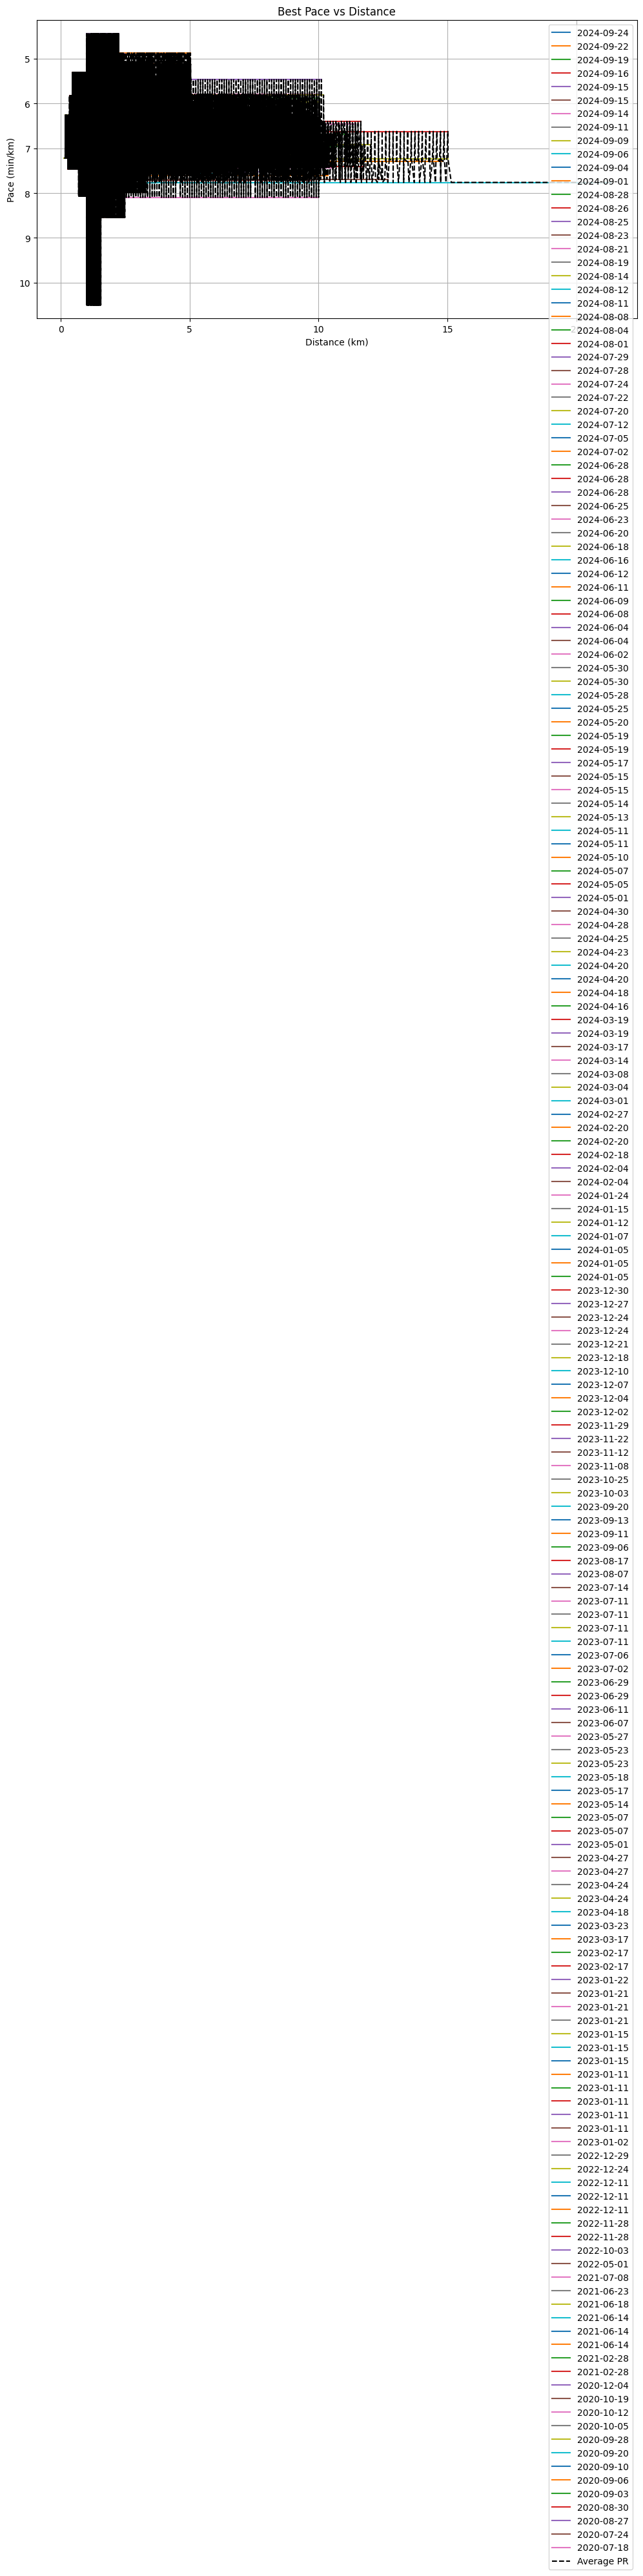

In [4]:
import matplotlib.pyplot as plt

# Collect data for plotting
plot_data = []

for idx, row in running_df.iterrows():
    total_distance = row['distance']  # in meters
    total_time = row['moving_time']  # in seconds
    pace = total_time / total_distance  # seconds per meter

    # Generate distances up to total_distance
    distances = np.linspace(1000, total_distance, num=100)  # Adjust num for resolution
    times = distances * pace  # times for the distances
    paces = (times / distances) * 1000  # pace in sec/km

    plot_data.append({
        'distances': distances / 1000,  # Convert to km
        'paces': paces / 60,  # Convert to min/km
        'date': row['start_date'],
        'run_id': row['id']
    })

# Plotting
plt.figure(figsize=(12, 6))

for run in plot_data:
    plt.plot(run['distances'], run['paces'], label=run['date'].strftime('%Y-%m-%d'))

# Calculate average PR curve
all_distances = np.array([])
all_paces = np.array([])

for run in plot_data:
    all_distances = np.concatenate((all_distances, run['distances']))
    all_paces = np.concatenate((all_paces, run['paces']))

# Create average PR curve
df_plot = pd.DataFrame({'distance': all_distances, 'pace': all_paces})
average_pr = df_plot.groupby('distance').min().reset_index()
plt.plot(average_pr['distance'], average_pr['pace'], '--', color='black', label='Average PR')

plt.xlabel('Distance (km)')
plt.ylabel('Pace (min/km)')
plt.title('Best Pace vs Distance')
plt.legend()
plt.gca().invert_yaxis()  # Faster pace at top
plt.grid(True)
plt.show()


# Create an Animated History of PRs
Show how your PRs have evolved over time.

# Approach
For each run in chronological order, update the PR curve.
Generate a plot for each step.
Combine the plots into an animated GIF.
Implementation

In [5]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import imageio
from tqdm import tqdm

# Sort runs by date
running_df.sort_values('start_date', inplace=True)
running_df.reset_index(drop=True, inplace=True)

# Initialize PR curve
pr_curve = pd.DataFrame(columns=['distance', 'pace'])

# List to store frames
filenames = []

# Create a directory to store frames
import os
if not os.path.exists('frames'):
    os.makedirs('frames')

# Iterate over runs
for idx, row in tqdm(running_df.iterrows(), total=running_df.shape[0]):
    total_distance = row['distance']
    total_time = row['moving_time']
    pace = total_time / total_distance

    distances = np.linspace(1000, total_distance, num=50)
    times = distances * pace
    paces = (times / distances) * 1000

    run_df = pd.DataFrame({
        'distance': distances / 1000,  # km
        'pace': paces / 60  # min/km
    })

    # Update PR curve
    if pr_curve.empty:
        pr_curve = run_df.copy()
    else:
        combined = pd.concat([pr_curve, run_df])
        pr_curve = combined.groupby('distance').min().reset_index()

    # Plot current PR curve and the run
    plt.figure(figsize=(12, 6))
    plt.plot(run_df['distance'], run_df['pace'], label=f"Run on {row['start_date'].date()}")
    plt.plot(pr_curve['distance'], pr_curve['pace'], '--', color='black', label='Current PR')
    plt.xlabel('Distance (km)')
    plt.ylabel('Pace (min/km)')
    plt.title(f'PR Evolution up to {row["start_date"].date()}')
    plt.legend()
    plt.gca().invert_yaxis()
    plt.grid(True)

    # Save frame
    filename = f'frames/frame_{idx}.png'
    plt.savefig(filename)
    filenames.append(filename)
    plt.close()

# Create animated GIF
with imageio.get_writer('pr_history.gif', mode='I', duration=1) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

# Cleanup frames
for filename in set(filenames):
    os.remove(filename)
os.rmdir('frames')


100%|██████████| 187/187 [00:29<00:00,  6.34it/s]
C:\Users\fedil\AppData\Local\Temp\ipykernel_7696\1630117046.py:63: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


# Overview
We'll accomplish the following steps:

Fetch Detailed GPS Data: Use the Strava API to get detailed stream data (time, distance, lat/lng) for each run.
Process Each Run: Compute cumulative distances and times, and find the best pace over all possible sub-runs.
Efficiently Calculate Best Pace: Implement an algorithm to efficiently find the best average pace for all distances.
Plot the Best Pace vs. Distance: Create a plot that shows your best pace as a function of distance, considering all sub-runs.
Compare Individual Runs: Optionally, compare a specific run against your all-time PR curve.

Function to Refresh Access Token


In [11]:
import requests
import time

def get_access_token(client_id, client_secret, refresh_token):
    response = requests.post(
        url='https://www.strava.com/oauth/token',
        data={
            'client_id': client_id,
            'client_secret': client_secret,
            'refresh_token': refresh_token,
            'grant_type': 'refresh_token',
            'f': 'json'
        }
    )
    access_token = response.json()['access_token']
    expires_at = response.json()['expires_at']
    expires_in = response.json()['expires_in']
    return access_token, expires_at

Fetch Activity IDs

Assuming you have already fetched your activities and have their IDs.

In [8]:
# Load your activities DataFrame
activities_df = pd.read_csv('data/my_activity_data=20240926202601.csv')

# Filter for running activities
running_activities = activities_df[activities_df['sport_type'] == 'Run']
activity_ids = running_activities['id'].tolist()

Fetch Streams for Each Activity

We'll fetch the streams for each activity, which includes time, distance, and optionally altitude and velocity_smooth.

In [9]:
def fetch_activity_streams(activity_id, access_token):
    url = f'https://www.strava.com/api/v3/activities/{activity_id}/streams'
    headers = {
        'Authorization': f'Bearer {access_token}'
    }
    params = {
        'keys': 'time,distance',
        'key_by_type': 'true'
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch streams for activity {activity_id}")
        return None


Loop to Fetch All Streams


In [12]:
from tqdm import tqdm
import os
import json

# Directory to store stream data
if not os.path.exists('streams'):
    os.makedirs('streams')

access_token, expires_at = get_access_token(CLIENT_ID, CLIENT_SECRET, REFRESH_TOKEN)

for activity_id in tqdm(activity_ids):
    stream_file = f'streams/{activity_id}.json'
    if os.path.exists(stream_file):
        continue  # Skip if already fetched

    # Refresh token if expired
    if time.time() > expires_at - 100:
        access_token, expires_at = get_access_token(CLIENT_ID, CLIENT_SECRET, REFRESH_TOKEN)

    streams = fetch_activity_streams(activity_id, access_token)
    if streams:
        with open(stream_file, 'w') as f:
            json.dump(streams, f)
    time.sleep(1)  # To respect rate limits


 53%|█████▎    | 100/187 [02:14<01:54,  1.32s/it]

Failed to fetch streams for activity 10343006091


 54%|█████▍    | 101/187 [02:15<01:49,  1.27s/it]

Failed to fetch streams for activity 10327163603


 55%|█████▍    | 102/187 [02:16<01:45,  1.24s/it]

Failed to fetch streams for activity 10317205535


 55%|█████▌    | 103/187 [02:18<01:41,  1.21s/it]

Failed to fetch streams for activity 10301235570


 56%|█████▌    | 104/187 [02:19<01:39,  1.20s/it]

Failed to fetch streams for activity 10300663234


 56%|█████▌    | 105/187 [02:20<01:41,  1.23s/it]

Failed to fetch streams for activity 10231646116


 57%|█████▋    | 106/187 [02:21<01:37,  1.21s/it]

Failed to fetch streams for activity 10231646067


 57%|█████▋    | 107/187 [02:22<01:35,  1.19s/it]

Failed to fetch streams for activity 10171440787


 58%|█████▊    | 108/187 [02:24<01:37,  1.23s/it]

Failed to fetch streams for activity 9970731734


 58%|█████▊    | 109/187 [02:25<01:34,  1.21s/it]

Failed to fetch streams for activity 9970731733


 59%|█████▉    | 110/187 [02:26<01:31,  1.19s/it]

Failed to fetch streams for activity 9843006257


 59%|█████▉    | 111/187 [02:27<01:29,  1.18s/it]

Failed to fetch streams for activity 9841679288


 60%|█████▉    | 112/187 [02:28<01:28,  1.17s/it]

Failed to fetch streams for activity 9829996927


 60%|██████    | 113/187 [02:29<01:26,  1.17s/it]

Failed to fetch streams for activity 9668440893


 61%|██████    | 114/187 [02:31<01:28,  1.22s/it]

Failed to fetch streams for activity 9635914381


 61%|██████▏   | 115/187 [02:32<01:26,  1.20s/it]

Failed to fetch streams for activity 9450129927


 62%|██████▏   | 116/187 [02:33<01:24,  1.18s/it]

Failed to fetch streams for activity 9434252835


 63%|██████▎   | 117/187 [02:34<01:25,  1.23s/it]

Failed to fetch streams for activity 9434252831


 63%|██████▎   | 118/187 [02:36<01:26,  1.25s/it]

Failed to fetch streams for activity 9434252778


 64%|██████▎   | 119/187 [02:37<01:23,  1.23s/it]

Failed to fetch streams for activity 9434253025


 64%|██████▍   | 120/187 [02:38<01:20,  1.21s/it]

Failed to fetch streams for activity 9398044004


 65%|██████▍   | 121/187 [02:39<01:21,  1.24s/it]

Failed to fetch streams for activity 9377000785


 65%|██████▌   | 122/187 [02:41<01:18,  1.21s/it]

Failed to fetch streams for activity 9360094892


 66%|██████▌   | 123/187 [02:42<01:19,  1.24s/it]

Failed to fetch streams for activity 9360094879


 66%|██████▋   | 124/187 [02:43<01:18,  1.24s/it]

Failed to fetch streams for activity 9244710298


 67%|██████▋   | 125/187 [02:44<01:16,  1.23s/it]

Failed to fetch streams for activity 9244710146


 67%|██████▋   | 126/187 [02:45<01:13,  1.21s/it]

Failed to fetch streams for activity 9152297723


 68%|██████▊   | 127/187 [02:47<01:14,  1.24s/it]

Failed to fetch streams for activity 9128556106


 68%|██████▊   | 128/187 [02:48<01:11,  1.21s/it]

Failed to fetch streams for activity 9127301536


 69%|██████▉   | 129/187 [02:49<01:12,  1.26s/it]

Failed to fetch streams for activity 9101010964


 70%|██████▉   | 130/187 [02:50<01:10,  1.23s/it]

Failed to fetch streams for activity 9090481467


 70%|███████   | 131/187 [02:52<01:10,  1.26s/it]

Failed to fetch streams for activity 9069462942


 71%|███████   | 132/187 [02:53<01:10,  1.28s/it]

Failed to fetch streams for activity 9027092441


 71%|███████   | 133/187 [02:54<01:09,  1.29s/it]

Failed to fetch streams for activity 9027836805


 72%|███████▏  | 134/187 [02:56<01:06,  1.25s/it]

Failed to fetch streams for activity 8989340925


 72%|███████▏  | 135/187 [02:57<01:03,  1.22s/it]

Failed to fetch streams for activity 8966115863


 73%|███████▎  | 136/187 [02:58<01:01,  1.21s/it]

Failed to fetch streams for activity 8967241391


 73%|███████▎  | 137/187 [02:59<00:59,  1.19s/it]

Failed to fetch streams for activity 11615950910


 74%|███████▍  | 138/187 [03:00<00:57,  1.18s/it]

Failed to fetch streams for activity 8948906483


 74%|███████▍  | 139/187 [03:02<00:58,  1.22s/it]

Failed to fetch streams for activity 8914423160


 75%|███████▍  | 140/187 [03:03<00:58,  1.25s/it]

Failed to fetch streams for activity 8765901934


 75%|███████▌  | 141/187 [03:04<00:56,  1.22s/it]

Failed to fetch streams for activity 8728141069


 76%|███████▌  | 142/187 [03:05<00:54,  1.21s/it]

Failed to fetch streams for activity 8577637584


 76%|███████▋  | 143/187 [03:06<00:52,  1.19s/it]

Failed to fetch streams for activity 8577301662


 77%|███████▋  | 144/187 [03:08<00:53,  1.23s/it]

Failed to fetch streams for activity 8436814897


 78%|███████▊  | 145/187 [03:09<00:50,  1.21s/it]

Failed to fetch streams for activity 8428015576


 78%|███████▊  | 146/187 [03:10<00:49,  1.20s/it]

Failed to fetch streams for activity 8428015695


 79%|███████▊  | 147/187 [03:11<00:49,  1.23s/it]

Failed to fetch streams for activity 8427730993


 79%|███████▉  | 148/187 [03:12<00:47,  1.21s/it]

Failed to fetch streams for activity 8395904164


 80%|███████▉  | 149/187 [03:14<00:47,  1.25s/it]

Failed to fetch streams for activity 8395904102


 80%|████████  | 150/187 [03:15<00:45,  1.22s/it]

Failed to fetch streams for activity 8395372854


 81%|████████  | 151/187 [03:16<00:43,  1.20s/it]

Failed to fetch streams for activity 8373120257


 81%|████████▏ | 152/187 [03:17<00:43,  1.25s/it]

Failed to fetch streams for activity 8373120374


 82%|████████▏ | 153/187 [03:19<00:41,  1.22s/it]

Failed to fetch streams for activity 8373120281


 82%|████████▏ | 154/187 [03:20<00:39,  1.20s/it]

Failed to fetch streams for activity 8373120341


 83%|████████▎ | 155/187 [03:21<00:39,  1.24s/it]

Failed to fetch streams for activity 8373120228


 83%|████████▎ | 156/187 [03:22<00:39,  1.26s/it]

Failed to fetch streams for activity 8324838227


 84%|████████▍ | 157/187 [03:24<00:38,  1.28s/it]

Failed to fetch streams for activity 8307456017


 84%|████████▍ | 158/187 [03:25<00:36,  1.24s/it]

Failed to fetch streams for activity 8287591283


 85%|████████▌ | 159/187 [03:26<00:34,  1.22s/it]

Failed to fetch streams for activity 8235755229


 86%|████████▌ | 160/187 [03:27<00:33,  1.25s/it]

Failed to fetch streams for activity 8235755249


 86%|████████▌ | 161/187 [03:29<00:31,  1.22s/it]

Failed to fetch streams for activity 8235550009


 87%|████████▋ | 162/187 [03:30<00:31,  1.25s/it]

Failed to fetch streams for activity 8180538494


 87%|████████▋ | 163/187 [03:31<00:30,  1.27s/it]

Failed to fetch streams for activity 8180479096


 88%|████████▊ | 164/187 [03:32<00:28,  1.24s/it]

Failed to fetch streams for activity 10290297492


 88%|████████▊ | 165/187 [03:34<00:26,  1.21s/it]

Failed to fetch streams for activity 10290297473


 89%|████████▉ | 166/187 [03:35<00:26,  1.24s/it]

Failed to fetch streams for activity 10290286308


 89%|████████▉ | 167/187 [03:36<00:24,  1.22s/it]

Failed to fetch streams for activity 10290286319


 90%|████████▉ | 168/187 [03:37<00:23,  1.25s/it]

Failed to fetch streams for activity 10290286307


 90%|█████████ | 169/187 [03:38<00:21,  1.22s/it]

Failed to fetch streams for activity 10290286295


 91%|█████████ | 170/187 [03:40<00:21,  1.25s/it]

Failed to fetch streams for activity 10290286294


 91%|█████████▏| 171/187 [03:41<00:20,  1.28s/it]

Failed to fetch streams for activity 10290286300


 92%|█████████▏| 172/187 [03:42<00:19,  1.29s/it]

Failed to fetch streams for activity 10290286303


 93%|█████████▎| 173/187 [03:44<00:17,  1.25s/it]

Failed to fetch streams for activity 10290286289


 93%|█████████▎| 174/187 [03:45<00:16,  1.28s/it]

Failed to fetch streams for activity 10290286232


 94%|█████████▎| 175/187 [03:46<00:15,  1.29s/it]

Failed to fetch streams for activity 10290286220


 94%|█████████▍| 176/187 [03:48<00:14,  1.30s/it]

Failed to fetch streams for activity 10290286217


 95%|█████████▍| 177/187 [03:49<00:13,  1.30s/it]

Failed to fetch streams for activity 10290286216


 95%|█████████▌| 178/187 [03:50<00:11,  1.26s/it]

Failed to fetch streams for activity 10290286225


 96%|█████████▌| 179/187 [03:51<00:09,  1.23s/it]

Failed to fetch streams for activity 10290286218


 96%|█████████▋| 180/187 [03:53<00:08,  1.26s/it]

Failed to fetch streams for activity 10290286192


 97%|█████████▋| 181/187 [03:54<00:07,  1.28s/it]

Failed to fetch streams for activity 9009284547


 97%|█████████▋| 182/187 [03:55<00:06,  1.29s/it]

Failed to fetch streams for activity 10290286172


 98%|█████████▊| 183/187 [03:57<00:05,  1.30s/it]

Failed to fetch streams for activity 10290286167


 98%|█████████▊| 184/187 [03:58<00:03,  1.31s/it]

Failed to fetch streams for activity 10290286168


 99%|█████████▉| 185/187 [03:59<00:02,  1.26s/it]

Failed to fetch streams for activity 10290286166


 99%|█████████▉| 186/187 [04:00<00:01,  1.23s/it]

Failed to fetch streams for activity 10290286182


100%|██████████| 187/187 [04:01<00:00,  1.29s/it]


Note:

Rate Limits: Strava imposes rate limits. Be sure to handle these appropriately.
Caching: We store the streams locally to avoid redundant API calls.

From Strava API documentation:

### Rate Limits
Strava API usage is limited on a per-application basis using both a 15-minute and daily request limit. Applications have an overall rate limit as well as a separate rate limit associated with the endpoints we consider “non-upload” endpoints. The default overall rate limit allows 200 requests every 15 minutes, with up to 2,000 requests per day. The default “non-upload” rate limit allows 100 requests every 15 minutes, with up to 1,000 requests per day.


# Process Each Run
We will process the streams to compute cumulative distances and times and find the best pace over all possible sub-runs.

## Function to Process a Single Run

In [28]:
def process_run(activity_id):
    stream_file = f'streams/{activity_id}.json'
    with open(stream_file, 'r') as f:
        streams = json.load(f)

    time_data = streams['time']['data']  # Cumulative time in seconds
    distance_data = streams['distance']['data']  # Cumulative distance in meters

    return time_data, distance_data


## Efficiently Calculate Best Pace
We need an efficient algorithm to find the best (lowest) average pace for all possible distances.

### Algorithm Explanation
To avoid the computational complexity of checking all possible sub-runs (O(n^2)), we can use a sliding window approach.

However, for variable distances, a more efficient method is to:

For each possible distance increment (e.g., every 10 meters), keep track of the minimal time (and thus minimal pace) needed to cover that distance.
We can also use a prefix sum array and dynamic programming techniques to optimize the process.

### Implementation

In [29]:
import numpy as np

def compute_best_pace(time_data, distance_data, min_distance=100, max_distance=None, step=10):
    """
    Computes the best pace over all possible sub-runs.

    Parameters:
    - time_data: list of cumulative time (seconds)
    - distance_data: list of cumulative distance (meters)
    - min_distance: minimum distance to consider (meters)
    - max_distance: maximum distance to consider (meters)
    - step: distance increment to consider (meters)

    Returns:
    - distances: array of distances considered
    - best_paces: array of best paces (seconds per km) at each distance
    """
    n = len(time_data)
    if max_distance is None:
        max_distance = distance_data[-1]

    distances = np.arange(min_distance, max_distance + step, step)
    best_paces = np.full_like(distances, np.inf, dtype=float)

    # Build arrays for efficient computation
    time_array = np.array(time_data)
    distance_array = np.array(distance_data)

    # For each possible start index
    for i in range(n):
        # For each possible end index from i+1 to n
        for j in range(i + 1, n):
            dist = distance_array[j] - distance_array[i]
            if dist < min_distance:
                continue
            if dist > max_distance:
                break  # Since distance is cumulative, no need to check further

            time = time_array[j] - time_array[i]
            pace = (time / dist) * 1000  # seconds per km

            # Find the index in distances array
            idx = int((dist - min_distance) / step)
            if pace < best_paces[idx]:
                best_paces[idx] = pace

    return distances, best_paces

# This approach may still be computationally heavy for large datasets.
# To optimize further, consider limiting the number of points or implementing more efficient algorithms.



### Making the PR Curve (logarithmic regression)

In [33]:
import numpy as np
from scipy import optimize

def logarithmic_regression(x, a, b):
    return a + b * np.log(x)

def fit_logarithmic_regression(distances, paces):
    # Remove any infinite or NaN values
    valid_indices = np.isfinite(paces)
    valid_distances = distances[valid_indices]
    valid_paces = paces[valid_indices]
    
    # Fit the logarithmic regression
    params, _ = optimize.curve_fit(logarithmic_regression, valid_distances, valid_paces)
    return params

## Plot the Best Pace vs. Distance
We can now plot the best pace as a function of distance.

### Process All Runs

In [34]:
def compute_overall_best_pace(activity_ids, min_distance=100, max_distance=50000, step=100):
    distances = np.arange(min_distance, max_distance + step, step)
    overall_best_paces = np.full_like(distances, np.inf, dtype=float)

    for activity_id in tqdm(activity_ids):
        try:
            time_data, distance_data = process_run(activity_id)
        except FileNotFoundError:
            print(f"File not found for activity {activity_id}. Skipping...")
            continue

        max_run_distance = distance_data[-1]
        activity_max_distance = min(max_distance, max_run_distance)
        activity_distances, activity_best_paces = compute_best_pace(
            time_data,
            distance_data,
            min_distance=min_distance,
            max_distance=activity_max_distance,
            step=step
        )

        # Update overall best paces
        for idx, pace in enumerate(activity_best_paces):
            if pace < overall_best_paces[idx]:
                overall_best_paces[idx] = pace
                
    # Calculate logarithmic regression curve
    a, b = fit_logarithmic_regression(distances, overall_best_paces)
    regression_curve = logarithmic_regression(distances, a, b)
    
    return distances, overall_best_paces, regression_curve


## Plotting 

In [35]:
import matplotlib.pyplot as plt

def plot_best_pace_vs_distance(distances, best_paces, regression_curve, min_distance, max_distance, step):
    # Convert pace to min/km
    paces_min_per_km = best_paces / 60
    regression_min_per_km = regression_curve / 60

    plt.figure(figsize=(12, 6))
    plt.plot(distances / 1000, paces_min_per_km, label='Best Pace')
    plt.plot(distances / 1000, regression_min_per_km, '--', label='Logarithmic Regression', color='red')
    plt.xlabel('Distance (km)')
    plt.ylabel('Best Pace (min/km)')
    plt.title('Best Pace vs Distance')
    plt.gca().invert_yaxis()  # Lower paces (faster) at the top
    plt.grid(True)
    plt.legend()
    
    # Save the plot with parameters in the filename
    plot_filename = f'best_pace_vs_distance_min{min_distance}_max{max_distance}_step{step}.png'
    plt.savefig(plot_filename)
    plt.show()
    
    print(f"Plot saved as {plot_filename}")


## Execute the Analysis


100%|██████████| 187/187 [06:54<00:00,  2.22s/it]


File not found for activity 10343006091. Skipping...
File not found for activity 10327163603. Skipping...
File not found for activity 10317205535. Skipping...
File not found for activity 10301235570. Skipping...
File not found for activity 10300663234. Skipping...
File not found for activity 10231646116. Skipping...
File not found for activity 10231646067. Skipping...
File not found for activity 10171440787. Skipping...
File not found for activity 9970731734. Skipping...
File not found for activity 9970731733. Skipping...
File not found for activity 9843006257. Skipping...
File not found for activity 9841679288. Skipping...
File not found for activity 9829996927. Skipping...
File not found for activity 9668440893. Skipping...
File not found for activity 9635914381. Skipping...
File not found for activity 9450129927. Skipping...
File not found for activity 9434252835. Skipping...
File not found for activity 9434252831. Skipping...
File not found for activity 9434252778. Skipping...
File

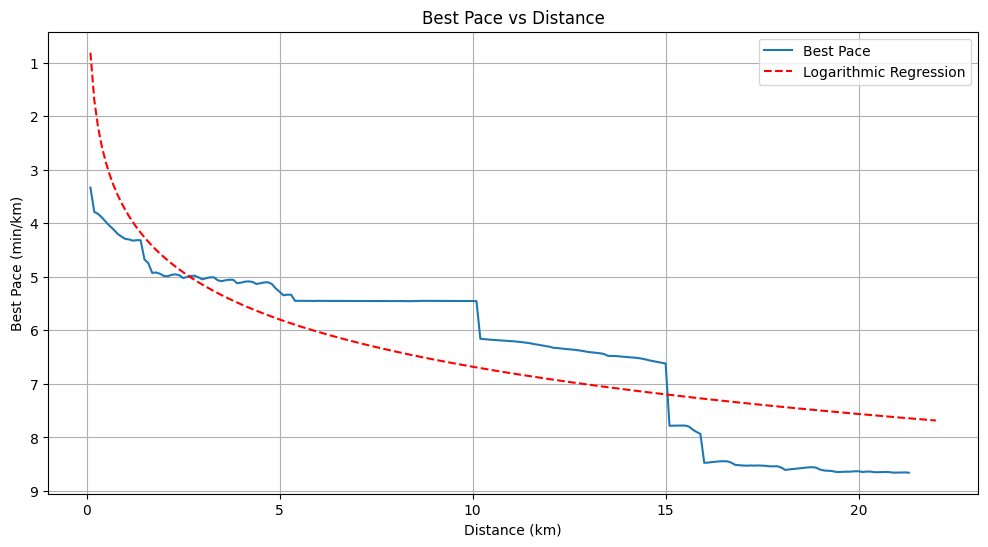

Plot saved as best_pace_vs_distance_min100_max22000_step100.png


In [36]:
# Set parameters
MIN_DISTANCE = 100  # meters
MAX_DISTANCE = 22000  # meters (22 km)
STEP = 100  # meters

distances, best_paces, regression_curve = compute_overall_best_pace(
    activity_ids,
    min_distance=MIN_DISTANCE,
    max_distance=MAX_DISTANCE,
    step=STEP
)

# Save the data to a CSV file with parameters in the filename
csv_filename = f'best_pace_data_min{MIN_DISTANCE}_max{MAX_DISTANCE}_step{STEP}.csv'
df = pd.DataFrame({
    'distance': distances,
    'best_pace': best_paces,
    'regression_curve': regression_curve
})
df.to_csv(csv_filename, index=False)
print(f"Data saved as {csv_filename}")

# Plot and save the graph
plot_best_pace_vs_distance(distances, best_paces, regression_curve, MIN_DISTANCE, MAX_DISTANCE, STEP)


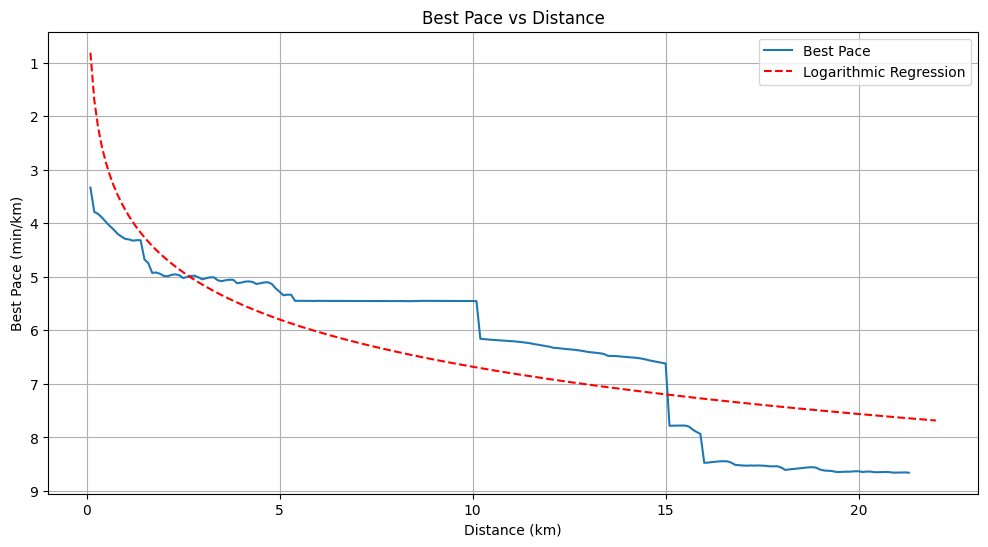

Plot saved as best_pace_vs_distance_min100_max22000_step100.png


In [38]:
#To load and use the saved data in future sessions, you can do:
import pandas as pd
import matplotlib.pyplot as plt

# Define the parameters used
MIN_DISTANCE = 100
MAX_DISTANCE = 22000
STEP = 100

# Load the saved data
csv_filename = f'best_pace_data_min{MIN_DISTANCE}_max{MAX_DISTANCE}_step{STEP}.csv'
df = pd.read_csv(csv_filename)

# Plot using the loaded data
plot_best_pace_vs_distance(df['distance'], df['best_pace'], df['regression_curve'], MIN_DISTANCE, MAX_DISTANCE, STEP)


## Compare Individual Runs
You can compare a specific run against your all-time PR curve.

In [39]:
# Compute Best Pace for a Specific Run
def compute_run_pace(activity_id, min_distance=100, max_distance=None, step=100):
    time_data, distance_data = process_run(activity_id)
    max_run_distance = distance_data[-1]
    if max_distance is None or max_distance > max_run_distance:
        max_distance = max_run_distance

    distances, best_paces = compute_best_pace(
        time_data,
        distance_data,
        min_distance=min_distance,
        max_distance=max_distance,
        step=step
    )
    return distances, best_paces


In [40]:
# Plot comparison
def plot_run_vs_pr(distances, overall_best_paces, run_paces, run_date):
    import matplotlib.pyplot as plt

    # Convert pace to min/km
    overall_paces_min_per_km = overall_best_paces / 60
    run_paces_min_per_km = run_paces / 60

    plt.figure(figsize=(12, 6))
    plt.plot(distances / 1000, overall_paces_min_per_km, label='All-time PR')
    plt.plot(distances / 1000, run_paces_min_per_km, label=f'Run on {run_date}')
    plt.xlabel('Distance (km)')
    plt.ylabel('Pace (min/km)')
    plt.title('Run vs All-time PR')
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.legend()
    plt.show()



### Execute the Comparison


ValueError: x and y must have same first dimension, but have shapes (72,) and (220,)

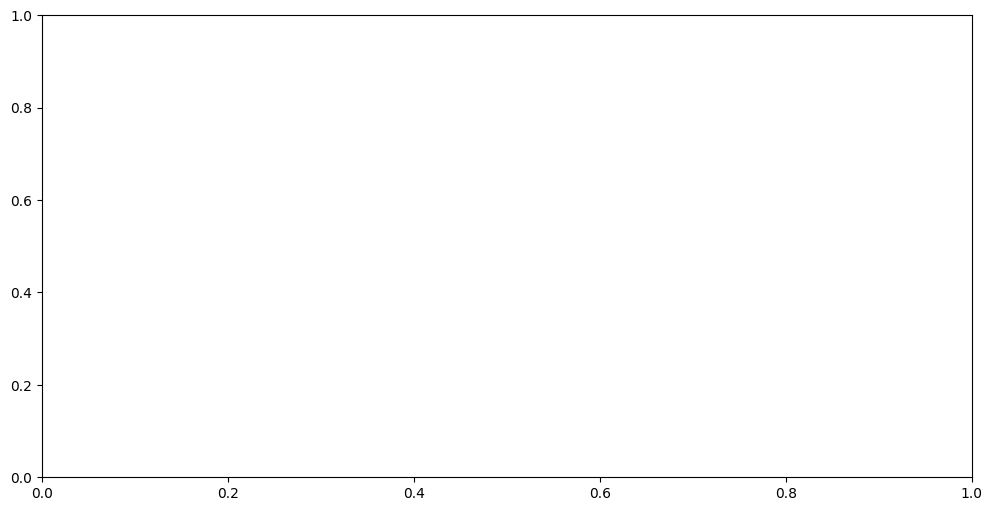

In [41]:
# Choose a run to compare
activity_id = activity_ids[0]  # Replace with desired activity ID

# Compute run pace
run_distances, run_best_paces = compute_run_pace(
    activity_id,
    min_distance=MIN_DISTANCE,
    max_distance=MAX_DISTANCE,
    step=STEP
)

# Get run date
run_date = running_activities[running_activities['id'] == activity_id]['start_date'].values[0]

# Plot comparison
plot_run_vs_pr(run_distances, best_paces, run_best_paces, run_date)
